In [1]:
import gzip
import csv
import random
import numpy
import math
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn import linear_model

In [2]:
def readGz(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)

In [3]:
def readCSV(path):
    f = gzip.open(path, 'rt')
    c = csv.reader(f)
    header = next(c)
    for l in c:
        d = dict(zip(header,l))
        yield d['user_id'],d['recipe_id'],d

In [4]:
def getHeader(path):
    f = gzip.open(path, 'rt', encoding = "utf8")
    header = f.readline()
    header = header.strip().split('\t')
    header = header[0].split(',')
    return header

In [5]:
data = []
train = []
valid = []

Load in data and split the training data (‘trainInteractions.csv.gz’) as follows:\
(1) Reviews 1-400,000 for training\
(2) Reviews 400,000-500,000 for validation

In [6]:
for user,recipe,d in readCSV("trainInteractions.csv.gz"):
    data.append(d)

In [7]:
header = getHeader("trainInteractions.csv.gz")

In [8]:
train = data[:450000]
valid = data[450000:]

Useful precalculation

In [9]:
recipeCount = defaultdict(int)
totalCooked = 0
userSet = set()
recipeSet = set()
userPerRecipe = defaultdict(set)
recipePerUser = defaultdict(set)
ratingDict = {}

In [10]:
for d in data:
    user,recipe = d['user_id'], d['recipe_id']
    recipeCount[recipe] += 1
    totalCooked += 1
    userSet.add(user)
    recipeSet.add(recipe)
    userPerRecipe[recipe].add(user)
    recipePerUser[user].add(recipe)
    ratingDict[(user,recipe)] = int(d['rating'])

In [11]:
userAverages = {}
recipeAverages = {}

for u in recipePerUser:
    rs = [ratingDict[(u,i)] for i in recipePerUser[u]]
    if len(rs) == 0:
        userAverages[u] = 0
        continue
    userAverages[u] = sum(rs) / len(rs)
    
for i in userPerRecipe:
    rs = [ratingDict[(u,i)] for u in userPerRecipe[i]]
    if len(rs) == 0:
        recipeAverages[i] = 0
        continue
    recipeAverages[i] = sum(rs) / len(rs)

Jaccard

In [12]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return 0
    return numer / denom

Cosine

In [13]:
def Cosine(i1, i2):
    # Between two items
    inter = userPerRecipe[i1].intersection(userPerRecipe[i2])
    numer = 0
    denom1 = 0
    denom2 = 0
    for u in inter:
        numer += ratingDict[(u,i1)]*ratingDict[(u,i2)]
    for u in userPerRecipe[i1]:
        denom1 += ratingDict[(u,i1)]**2
    for u in userPerRecipe[i2]:
        denom2 += ratingDict[(u,i2)]**2
    denom = math.sqrt(denom1) * math.sqrt(denom2)
    if denom == 0: return 0
    return numer / denom

Pearson Similarity

In [14]:
def Pearson(i1, i2):
    # Between two items
    if i1 in recipeAverages:
        iBar1 = recipeAverages[i1]
    else:
        iBar1 = 0
    if i2 in recipeAverages:
        iBar2 = recipeAverages[i2]
    else:
        iBar2 = 0
    inter = userPerRecipe[i1].intersection(userPerRecipe[i2])
    numer = 0
    denom1 = 0
    denom2 = 0
    for u in inter:
        numer += (ratingDict[(u,i1)] - iBar1)*(ratingDict[(u,i2)] - iBar2)
    for u in inter: #usersPerItem[i1]:
        denom1 += (ratingDict[(u,i1)] - iBar1)**2
    #for u in usersPerItem[i2]:
        denom2 += (ratingDict[(u,i2)] - iBar2)**2
    denom = math.sqrt(denom1) * math.sqrt(denom2)
    if denom == 0: return 0
    return numer / denom

In [15]:
def Q3():
    thresholds = numpy.arange(-0.5, 0.6, 0.1)
    res = []
    for threshold in thresholds:
        correct = 0
        for d in valid:
            similarities = [0]
            userCooked = recipePerUser[d['user_id']]
            for recipe in userCooked:
                similarities.append(Pearson(d['recipe_id'], recipe))
                
            if max(similarities) > threshold:
                correct += (d['rating'] != '0')

        res.append(correct/len(valid))
        print(correct/len(valid))
        print(threshold)

    plt.plot(thresholds, res, 'b-')
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy for different thresholds')
    plt.show()
    return res

0.97588
-0.5
0.97588
-0.4
0.97588
-0.30000000000000004
0.97588
-0.20000000000000007
0.97588
-0.10000000000000009
0.97588
-1.1102230246251565e-16
0.44416
0.09999999999999987
0.44356
0.19999999999999984
0.44286
0.2999999999999998
0.44222
0.3999999999999998
0.44136
0.4999999999999998


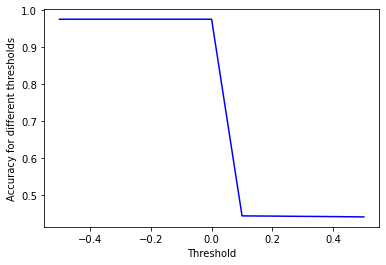

In [16]:
res = Q3()

In [17]:
print("Accuracy on Validation set with similarity threshold ", 0 + res.index(max(res)) * 0.1, " is")
print(max(res))

Accuracy on Validation set with similarity threshold  0.0  is
0.97588


Sim and pop on valid set

In [32]:
def Q4():
    
    pop_threshold = 1.77
    sim_threshold = 0
    
    mostPopular = [(recipeCount[x], x) for x in recipeCount]
    mostPopular.sort()
    mostPopular.reverse()

    return1 = set()
    count = 0
    for ic, i in mostPopular:
        count += ic
        return1.add(i)
        if count > totalCooked / pop_threshold:
            break

    correct = 0
    for d in valid:
        similarities = [0]
        userCooked = recipePerUser[d['user_id']]
        for recipe in userCooked:
            similarities.append(Pearson(d['recipe_id'], recipe))

        if max(similarities) > sim_threshold or d['recipe_id'] in return1:
            correct += (d['rating'] != '0')
            
#         if max(similarities) > sim_threshold:
#             correct += (d['rating'] != '0')
    
    print("Accuracy on Validation set with \npopularity threshold ", pop_threshold, 
          " (totalCooked / threshold) \nand similarity threshold ", sim_threshold, " is")
    print(correct/len(valid))

In [33]:
Q4()

Accuracy on Validation set with 
popularity threshold  1.77  (totalCooked / threshold) 
and similarity threshold  0  is
0.55432


Kaggle user name: ZiangX\
Score: 0.67190

In [18]:
def Q5():
    
    recipeCount = defaultdict(int)
    totalCooked = 0

    for user,recipe,_ in readCSV("trainInteractions.csv.gz"):
        recipeCount[recipe] += 1
        totalCooked += 1
    
    pop_threshold = 0.73
    sim_threshold = 0
    
    mostPopular = [(recipeCount[x], x) for x in recipeCount]
    mostPopular.sort()
    mostPopular.reverse()

    return1 = set()
    count = 0
    for ic, i in mostPopular:
        count += ic
        return1.add(i)
        if count > (totalCooked*pop_threshold):
            break               
                
    predictions = open("predictions_Made_ZZ.txt", 'w')
    for l in open("stub_Made.txt"):
        if l.startswith("user_id"):
            predictions.write(l)
            continue
        u,i = l.strip().split('-')
        similarities = [0]
        for recipe in recipePerUser[u]:
            similarities.append(Pearson(i, recipe)) 
        
        if max(similarities) > sim_threshold or i in return1:
            predictions.write(u + '-' + i + ",1\n")
        else:
            predictions.write(u + '-' + i + ",0\n")

    predictions.close()

In [19]:
Q5()